In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

In [3]:
df = pd.read_csv('mock_kaggle.csv')
df['data'] = pd.to_datetime(df['data'])
df.columns = ['date', 'sales', 'stock', 'price']

In [4]:
df.describe()

,date,sales,stock,price
count,937,937.000000,937.000000,937.000000
mean,2015-04-19 12:23:49.242262528,90.533618,1608.258271,1.592572
min,2014-01-01 00:00:00,0.000000,0.000000,0.000000
25%,2014-08-29 00:00:00,33.000000,794.000000,1.290000
50%,2015-04-20 00:00:00,76.000000,1348.000000,1.390000
75%,2015-12-10 00:00:00,127.000000,1964.000000,1.890000
max,2016-07-31 00:00:00,542.000000,7228.000000,2.980000
std,NaN,80.682089,1356.691877,0.529502


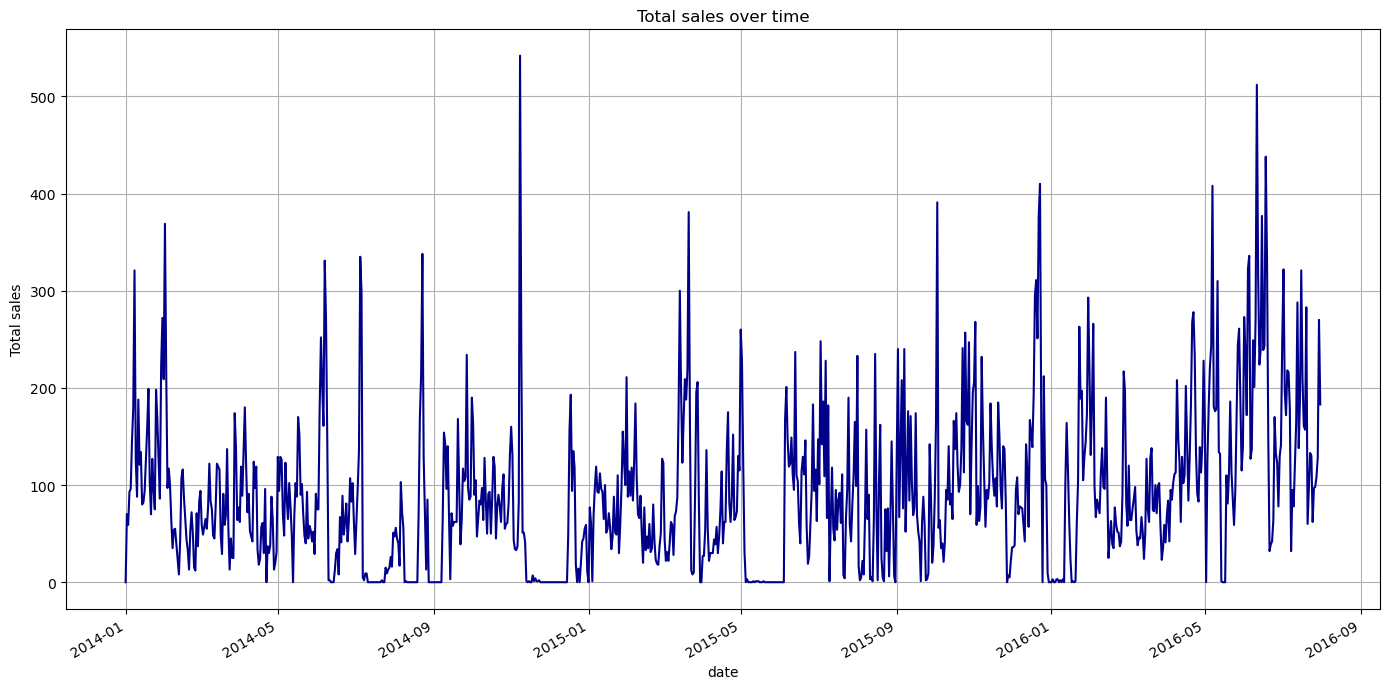

In [5]:
#analysis of the total sales and check the trend of sales by date as the x-label
daily_sales = df.groupby('date')['sales'].sum()
plt.figure(figsize=(14,7))
daily_sales.plot(color='darkblue')
plt.title('Total sales over time')
plt.xlabel("date")
plt.ylabel("Total sales")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Extracting temporal features from the date
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek #this will show the weekday effect
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0) #this will show the weekend effect

In [12]:
# Rolling statistics are helpful for models to capture short- and medium-term sales momentum.
df = df.sort_values('date')
# Rolling average and rolling sum of sales of past week
df['sales_rolling_mean_7'] = df['sales'].rolling(window=7).mean()
df['sales_rolling_sum_7'] = df['sales'].rolling(window=7).sum()
#Rolling average and rolling sum of sales of past month
df['sales_rolling_mean_30'] = df['sales'].rolling(window=30).mean()
df['sales_rolling_sum_30'] = df['sales'].rolling(window=30).sum()


In [14]:
# Lag features (previous day and previous week sales) -  this helps model to remember the past data too
df['lag_1'] = df['sales'].shift(1) #yesterday
df['lag_7'] = df['sales'].shift(7) #past week
df['lag_30'] = df['sales'].shift(30) #past month

In [16]:
# Price change day to day
df['price_change'] = df['price'].diff()

# Stock-to-sales ratio (how well is stock being utilized)
df['stock_sales_ratio'] = df['stock'] / (df['sales'] + 1)


C:\Users\NihilTej\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


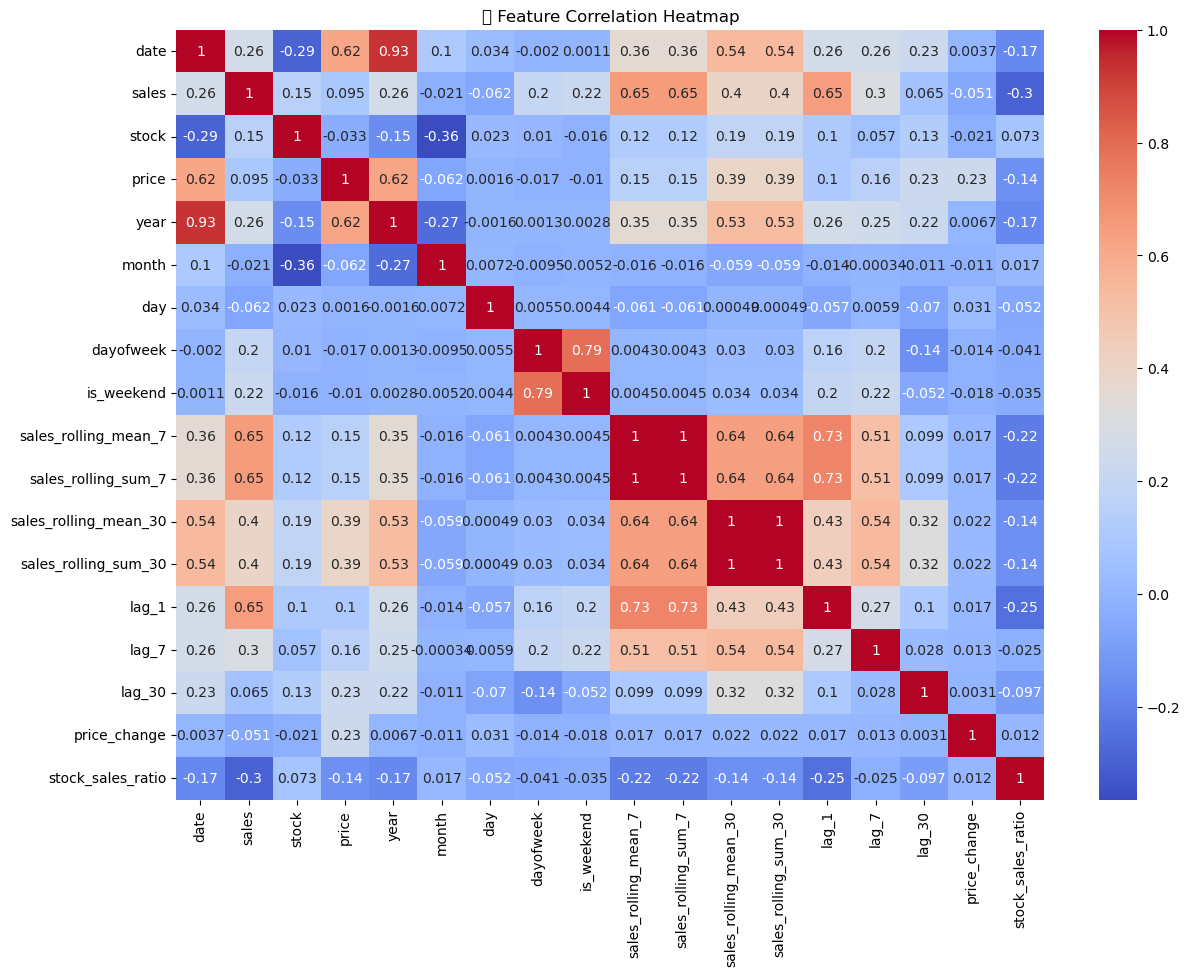

In [18]:
# Correlation heatmap to see relationships - to decide which features have strong relationships with sales.
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("🔍 Feature Correlation Heatmap")
plt.show()


In [20]:
# Drop rows with NaNs created due to rolling and lag
df_model = df.dropna().reset_index(drop=True)

# Preview the final feature-engineered data
df_model.head()


,date,sales,stock,price,year,month,day,dayofweek,is_weekend,sales_rolling_mean_7,sales_rolling_sum_7,sales_rolling_mean_30,sales_rolling_sum_30,lag_1,lag_7,lag_30,price_change,stock_sales_ratio
0,2014-02-01,369,2145,0.99,2014,2,1,5,1,207.285714,1451.0,145.133333,4354.0,209.0,198.0,0.0,0.0,5.797297
1,2014-02-02,217,1928,0.99,2014,2,2,6,1,214.285714,1500.0,150.033333,4501.0,369.0,168.0,70.0,0.0,8.844037
2,2014-02-03,97,1831,0.99,2014,2,3,0,0,210.285714,1472.0,151.300000,4539.0,217.0,125.0,59.0,0.0,18.683673
3,2014-02-04,117,1714,0.99,2014,2,4,1,0,214.714286,1503.0,152.100000,4563.0,97.0,86.0,93.0,0.0,14.525424
4,2014-02-05,100,1998,1.29,2014,2,5,2,0,197.285714,1381.0,152.233333,4567.0,117.0,222.0,96.0,0.3,19.782178


In [22]:
!pip install prophet

In [26]:
# Prepare dataframe for Prophet
df_prophet = df[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})
df_prophet = df_prophet.dropna()  # Drop missing values if any
df_prophet.head()


,ds,y
0,2014-01-01,0
1,2014-01-02,70
2,2014-01-03,59
3,2014-01-04,93
4,2014-01-05,96


In [28]:
# Initialize model
model = Prophet(daily_seasonality=True)

# Fit model on historical data
model.fit(df_prophet)


12:44:20 - cmdstanpy - INFO - Chain [1] start processing
12:44:20 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
# Create future dates for 30 days
future = model.make_future_dataframe(periods=30)

# Predict future sales
forecast = model.predict(future)

# Show forecasted values where yhat is predicted value and yhat_lower is min and yhat_upper is maxb
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
962,2016-08-26,163.820831,80.820535,243.324206
963,2016-08-27,216.595044,135.571285,301.603368
964,2016-08-28,172.294917,89.661357,252.434492
965,2016-08-29,144.946385,62.099239,227.490700
966,2016-08-30,143.170439,56.850149,230.647447


C:\Users\NihilTej\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


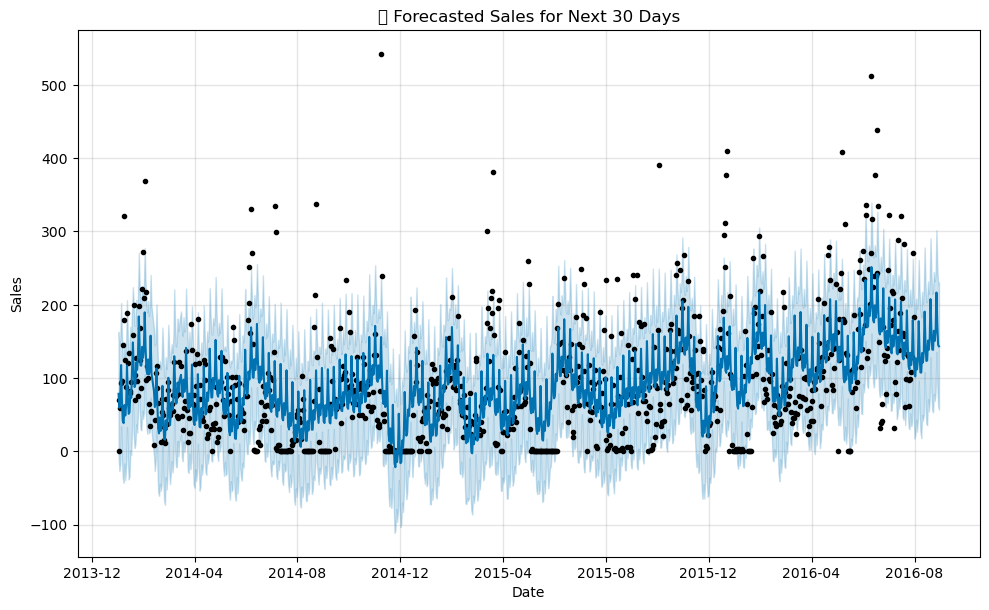

In [32]:
# Basic forecast plot
fig1 = model.plot(forecast)
plt.title("📈 Forecasted Sales for Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

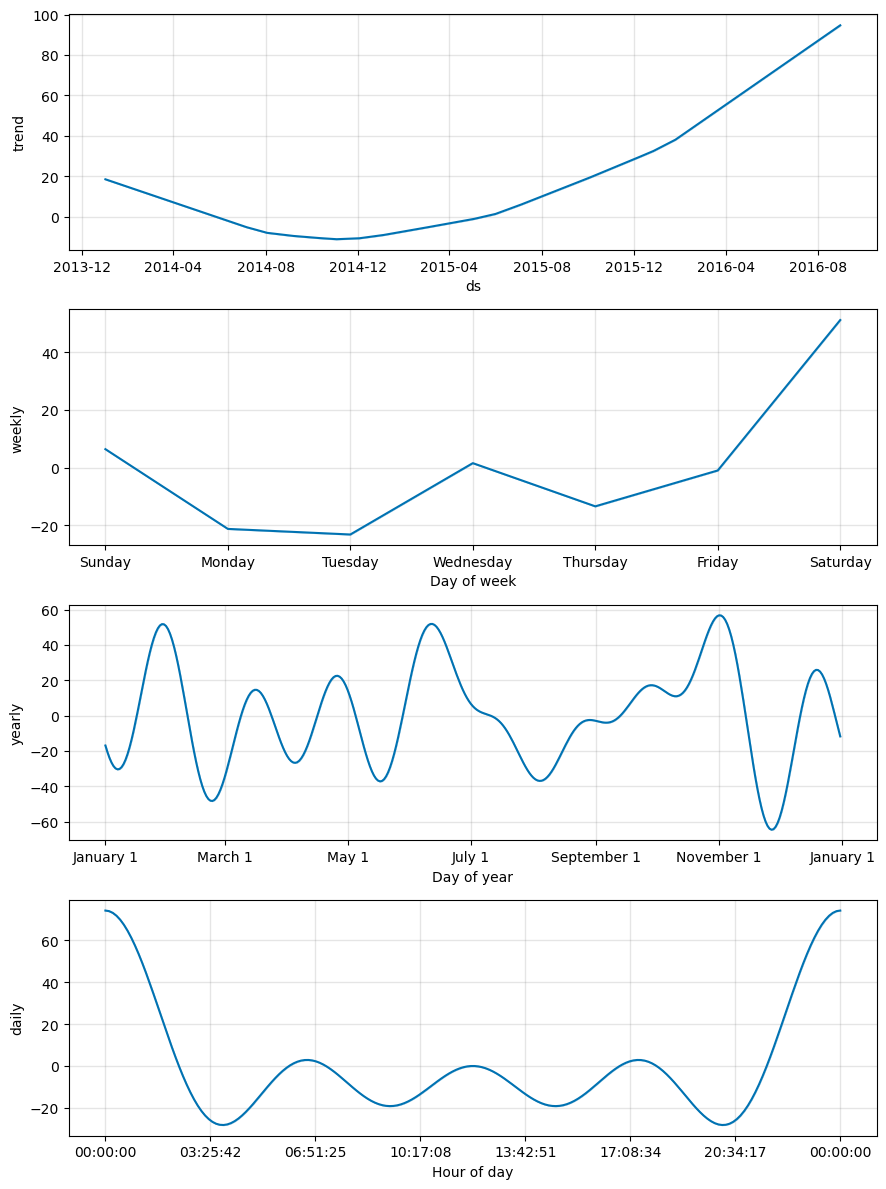

In [34]:
# Decomposition plot
fig2 = model.plot_components(forecast)

C:\Users\NihilTej\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


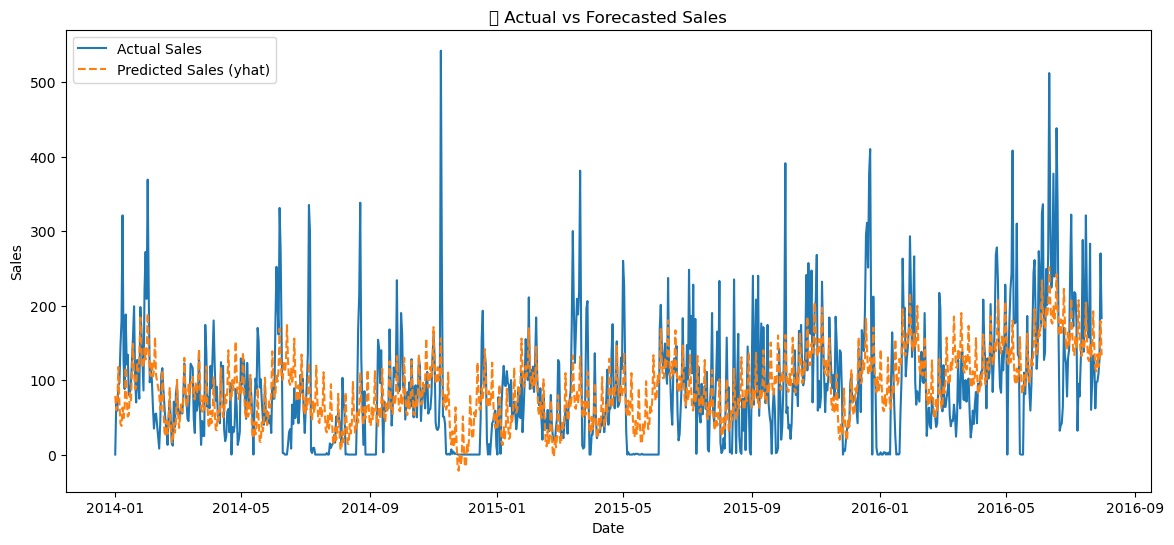

In [36]:
# Join actual vs. predicted
merged = df_prophet.merge(forecast[['ds', 'yhat']], on='ds', how='left')

# Plot actual vs predicted
plt.figure(figsize=(14,6))
plt.plot(merged['ds'], merged['y'], label='Actual Sales')
plt.plot(merged['ds'], merged['yhat'], label='Predicted Sales (yhat)', linestyle='--')
plt.title("🔍 Actual vs Forecasted Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

In [38]:
# Export forecast for Power BI dashboard
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('forecast_output.csv', index=False)